In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Question 1: Top 10 Bundesliga teams over entire period

**Metric: Points Per Game (PPG)**
- 3 points for win
- 1 point for draw
- 0 points for loss

In [325]:
# Load data
df = pd.read_csv('data/bundesliga.csv')

# Convert Date to datetime 
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# Quick look
print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
df.head()

Dataset shape: (7650, 11)

Date range: 1993-08-07 00:00:00 to 2018-05-12 00:00:00


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
0,D1,1993-08-07,Bayern Munich,Freiburg,3,1,H,NaN,NaN,NaN,1993-94
1,D1,1993-08-07,Dortmund,Karlsruhe,2,1,H,NaN,NaN,NaN,1993-94
2,D1,1993-08-07,Duisburg,Leverkusen,2,2,D,NaN,NaN,NaN,1993-94
3,D1,1993-08-07,FC Koln,Kaiserslautern,0,2,A,NaN,NaN,NaN,1993-94
4,D1,1993-08-07,Hamburg,Nurnberg,5,2,H,NaN,NaN,NaN,1993-94


In [326]:
# Check for missing values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Div       7650 non-null   str           
 1   Date      7650 non-null   datetime64[us]
 2   HomeTeam  7650 non-null   str           
 3   AwayTeam  7650 non-null   str           
 4   FTHG      7650 non-null   int64         
 5   FTAG      7650 non-null   int64         
 6   FTR       7650 non-null   str           
 7   HTHG      7038 non-null   float64       
 8   HTAG      7038 non-null   float64       
 9   HTR       7038 non-null   str           
 10  Season    7650 non-null   str           
dtypes: datetime64[us](1), float64(2), int64(2), str(6)
memory usage: 657.6 KB


## Calculate Points for Each Team

In [327]:
def calculate_team_stats(df):
    stats = {}
    
    # Process matches
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        result = row['FTR']
        
        # Initialize teams if not seen before
        if home_team not in stats:
            stats[home_team] = {'games': 0, 'points': 0}
        if away_team not in stats:
            stats[away_team] = {'games': 0, 'points': 0}
        
        # Update home team stats
        stats[home_team]['games'] += 1
        
        if result == 'H': 
            stats[home_team]['points'] += 3
        elif result == 'D':     
            stats[home_team]['points'] += 1
        
        # Update away team stats
        stats[away_team]['games'] += 1
        
        if result == 'A': 
            stats[away_team]['points'] += 3
        elif result == 'D':     
            stats[away_team]['points'] += 1
    
    return stats

In [328]:
# Calculate stats
team_stats = calculate_team_stats(df)

# Convert to df
stats_df = pd.DataFrame.from_dict(team_stats, orient='index')
stats_df.index.name = 'Team'
stats_df.reset_index(inplace=True)

# Calculate derived metrics
stats_df['PPG'] = stats_df['points'] / stats_df['games']

print(f"Total teams in dataset: {len(stats_df)}")
stats_df.head()

Total teams in dataset: 43


,Team,games,points,PPG
0,Bayern Munich,850,1820,2.141176
1,Freiburg,612,719,1.174837
2,Dortmund,850,1472,1.731765
3,Karlsruhe,238,306,1.285714
4,Duisburg,272,292,1.073529


In [329]:
# Filter teams with min 100 games and get top 10
min_games = 100

filtered_stats = stats_df[stats_df['games'] >= min_games]
top_10 = filtered_stats.sort_values('PPG', ascending=False).head(10)

print(f"=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===")
print(f"Filtered by minimum {min_games} games | Teams remaining: {len(filtered_stats)}\n")

# Reset index to start from 1
top_10_display = top_10[['Team', 'games', 'PPG']].reset_index(drop=True)
top_10_display.index = range(1, 11)
top_10_display

=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===
Filtered by minimum 100 games | Teams remaining: 27



,Team,games,PPG
1,Bayern Munich,850,2.141176
2,Dortmund,850,1.731765
3,Leverkusen,850,1.664706
4,Schalke 04,850,1.568235
5,Werder Bremen,850,1.494118
6,Stuttgart,816,1.441176
7,Kaiserslautern,476,1.394958
8,Hertha,646,1.385449
9,Wolfsburg,714,1.379552
10,Hamburg,850,1.350588


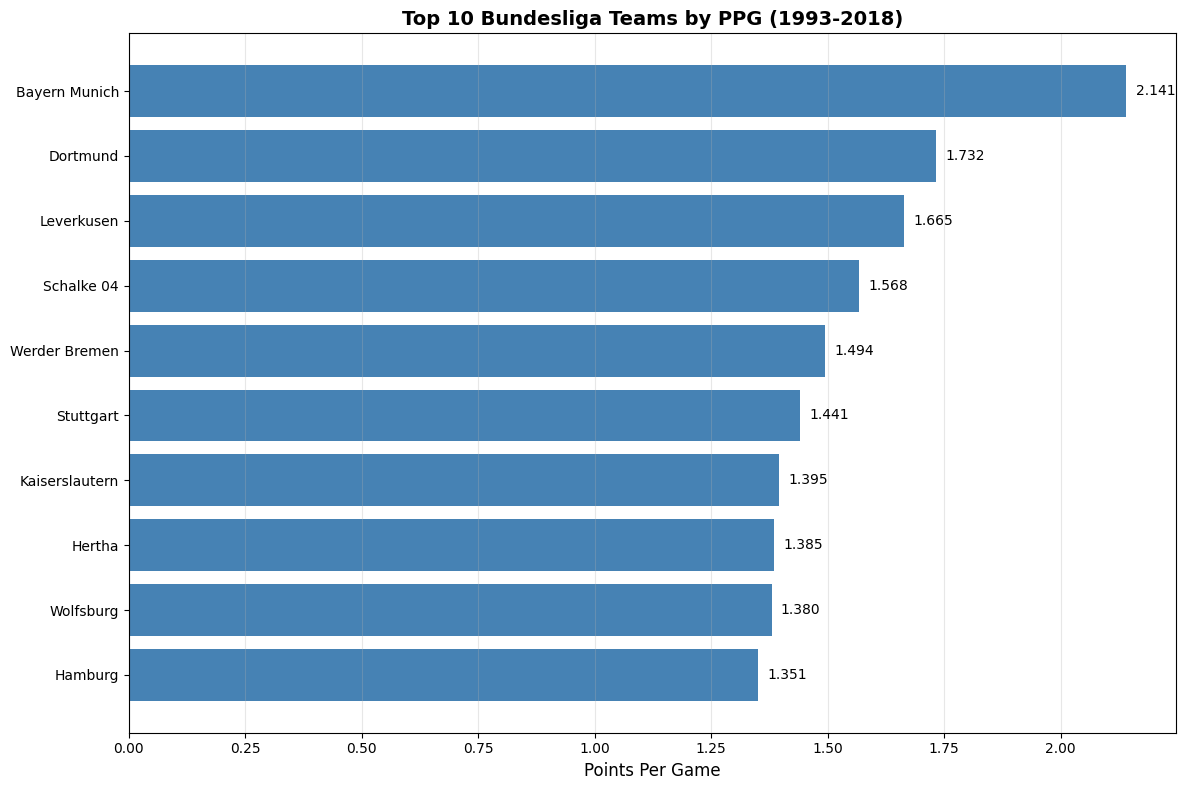

In [330]:
# Bar chart of top 10 teams
fig, ax = plt.subplots(figsize=(12, 8))

# PPG comparison
ax.barh(range(len(top_10)), top_10['PPG'].values, color='steelblue')
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['Team'].values)
ax.set_xlabel('Points Per Game', fontsize=12)
ax.set_title('Top 10 Bundesliga Teams by PPG (1993-2018)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10['PPG'].values):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Summary - Question 1

**Approach:**
The chosen metric is points per game (PPG) using FIFA's 3-1-0 point system (3 for win, 1 for draw, 0 for loss) mirroring reality and preventing skews due to draws. A filter of minimum 100 games is placed to ensure statistical significance and exclude short term performance as 2 teams initially placed in the top 10 without this constraint. The complete dataset is covered from 1993 to 2018.

**Key Findings:**
Bayern Munich dominates with 2.141 PPG, significantly ahead of other teams. Other established Bundesliga teams cluster in the 1.5-1.7 range, while the bottom tier consolidates around 1.4. The above horizontal bar chart shows this hierarchy.

## Question 2: Total goals prediction

A model is implemented to predict total goals in football matches. Since bets are placed at half time the target variable for prediction is the total goals in the second half of the matches. 

In [331]:
# Drop rows with missing halftime data (1993/94 and 1994/95 seasons)
df_clean = df.dropna(subset=['HTHG', 'HTAG', 'HTR']).copy()

print(f"\nAfter dropping missing halftime data: {df_clean.shape}")
print(f"Rows dropped: {len(df) - len(df_clean)}")


After dropping missing halftime data: (7038, 11)
Rows dropped: 612


In [332]:
# Target variable: Total goals in second half
df_clean['second_half_goals'] = (df_clean['FTHG'] - df_clean['HTHG']) + (df_clean['FTAG'] - df_clean['HTAG'])

# Halftime features
df_clean['ht_total_goals'] = df_clean['HTHG'] + df_clean['HTAG']
df_clean['ht_goal_diff'] = df_clean['HTHG'] - df_clean['HTAG']

df_clean['year'] = df_clean['Date'].dt.year

# Calculate running average of second half goals for each team.
def calculate_historical_avg(df, team_col):
    is_home = team_col == 'HomeTeam'
    team_avgs = {}
    result = []
    
    for _, row in df.iterrows():
        team = row[team_col]
        
        # Get average from prior matches only
        if team in team_avgs and team_avgs[team]['games'] > 0:
            avg = team_avgs[team]['sh_cumulative_goals'] / team_avgs[team]['games']
        else:
            avg = np.nan
        
        result.append(avg)
        
        # Update running totals after recording the average
        if team not in team_avgs:
            team_avgs[team] = {'sh_cumulative_goals': 0, 'games': 0}
        
        sh_goals = row['FTHG'] - row['HTHG'] if is_home else row['FTAG'] - row['HTAG']
        team_avgs[team]['sh_cumulative_goals'] += sh_goals
        team_avgs[team]['games'] += 1
    
    return result

# Calculate historical averages
df_clean['home_team_hist_sh_goals'] = calculate_historical_avg(df_clean, 'HomeTeam')
df_clean['away_team_hist_sh_goals'] = calculate_historical_avg(df_clean, 'AwayTeam')

# Fill NaNs: avg. about 0.8 goals per team per second half
AVG_SH_GOALS_PER_TEAM = 0.8

df_clean['home_team_hist_sh_goals'] = df_clean['home_team_hist_sh_goals'].fillna(AVG_SH_GOALS_PER_TEAM)
df_clean['away_team_hist_sh_goals'] = df_clean['away_team_hist_sh_goals'].fillna(AVG_SH_GOALS_PER_TEAM)

df_clean['combined_hist_sh_goals'] = df_clean['home_team_hist_sh_goals'] + df_clean['away_team_hist_sh_goals']

In [333]:
# Split: Train on data before 2016, test on 2016-2018
train_cutoff_year = 2016
train_df = df_clean[df_clean['year'] < train_cutoff_year].copy()
test_df = df_clean[df_clean['year'] >= train_cutoff_year].copy()

print(f"\n=== Train-Test Split ===")
print(f"Train set: {len(train_df)} matches ({train_df['year'].min()}-{train_df['year'].max()})")
print(f"Test set: {len(test_df)} matches ({test_df['year'].min()}-{test_df['year'].max()})")

# Features
feature_cols = [
    'ht_total_goals', 'ht_goal_diff',  # Half time features
    'home_team_hist_sh_goals',         # Historical: home team's avg 2nd half goals
    'away_team_hist_sh_goals',         # Historical: away team's avg 2nd half goals
]

X_train = train_df[feature_cols]
y_train = train_df['second_half_goals']

X_test = test_df[feature_cols]
y_test = test_df['second_half_goals']

print(f"\nFeatures used: {len(feature_cols)}")
for f in feature_cols:
    print(f"  - {f}")



=== Train-Test Split ===
Train set: 6273 matches (1995-2015)
Test set: 765 matches (2016-2018)

Features used: 4
  - ht_total_goals
  - ht_goal_diff
  - home_team_hist_sh_goals
  - away_team_hist_sh_goals


In [334]:
# Baseline model: Predict mean of training 
baseline_pred = np.full(len(y_test), y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\n=== Baseline (Predict Mean) ===")
print(f"Mean second half goals (train): {y_train.mean():.3f}")
print(f"MAE: {baseline_mae:.3f}")
print(f"RMSE: {baseline_rmse:.3f}")


=== Baseline (Predict Mean) ===
Mean second half goals (train): 1.619
MAE: 1.023
RMSE: 1.243


In [335]:
# Random Forest model
print(f"\nTraining Random Forest")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
)
rf_model.fit(X_train, y_train)

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

rf_mae_train = mean_absolute_error(y_train, rf_pred_train)
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_r2_train = r2_score(y_train, rf_pred_train)

rf_mae_test = mean_absolute_error(y_test, rf_pred_test)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2_test = r2_score(y_test, rf_pred_test)

print(f"\nTrain Performance:")
print(f"  MAE: {rf_mae_train:.3f}")
print(f"  RMSE: {rf_rmse_train:.3f}")
print(f"  R²: {rf_r2_train:.3f}")

print(f"\nTest Performance:")
print(f"  MAE: {rf_mae_test:.3f}")
print(f"  RMSE: {rf_rmse_test:.3f}")
print(f"  R²: {rf_r2_test:.3f}")


Training Random Forest

Train Performance:
  MAE: 0.955
  RMSE: 1.179
  R²: 0.111

Test Performance:
  MAE: 1.009
  RMSE: 1.231
  R²: 0.018


In [336]:
# Comparinng results
print("\n" + "="*50)
print("MODEL COMPARISON (Test Set)")
print("="*50)
comparison = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Random Forest'],
    'MAE': [baseline_mae, rf_mae_test],
    'RMSE': [baseline_rmse, rf_rmse_test],
    'R²': [0.0, rf_r2_test]
})
print(comparison.to_string(index=False))
print(f"\nMAE improvement: {((baseline_mae - rf_mae_test) / baseline_mae * 100):.1f}%")


MODEL COMPARISON (Test Set)
          Model      MAE     RMSE       R²
Baseline (Mean) 1.023213 1.242900 0.000000
  Random Forest 1.009327 1.231455 0.017787

MAE improvement: 1.4%


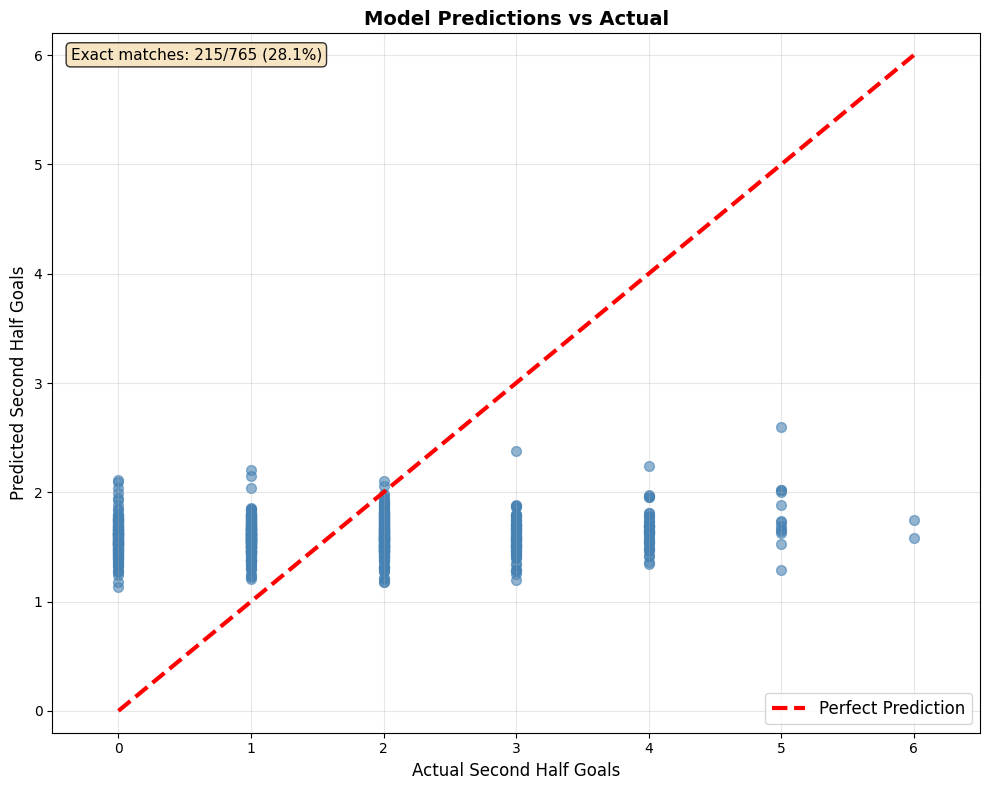

In [337]:
# Predicted vs Actual plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(y_test, rf_pred_test, alpha=0.6, color='steelblue', s=50)

min_val = 0
max_val = max(y_test.max(), rf_pred_test.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect Prediction')

ax.set_xlabel('Actual Second Half Goals', fontsize=12)
ax.set_ylabel('Predicted Second Half Goals', fontsize=12)
ax.set_title('Model Predictions vs Actual', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

ax.set_xlim(-0.5, max_val + 0.5)
ax.set_ylim(min_val - 0.2, max_val + 0.2)

exact_matches = (np.round(rf_pred_test) == y_test).sum()
total = len(y_test)
ax.text(0.02, 0.98, f'Exact matches: {exact_matches}/{total} ({exact_matches/total*100:.1f}%)', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

### Summary - Question 2: Total Goals Prediction

**Approach:**
The target variable is second half goals (total goals - halftime goals) since bets are placed at halftime. Feature engineering settled on halftime context: total goals and goal difference at half time + historical features: Running averages of each team's second-half scoring patterns. The model chosen is a random forest regressor with conservative hyperparameters to avoid overfitting, although first thought was a poisson regressor. Evaluation is performed using a chronological time based split (train: pre-2016, test: 2016-2018) to simulate real world deployment. 
Note: 1993-1995 data was excluded from this part due to missing half time data.

**Key findings:**
Test MAE and R² shows tiny improvement over baseline and a 28.1% hitrate when rounded to nearest integer. Model consistently over-predicts low-scoring games and under-predicts high-scoring ones, essentially just conservatively guessing the mean for every outcome. On the above figure, points clustered in narrow horizontal band show model only predicts 1.2-2.6 goals while actual games range 0-6+ goals. 

**Potential improvements**
The model has few features (4) as a result of poor performance with more features, both for poisson/random forest/XGBoost. Ideally more, and better features should improve model performance. 